In [18]:
%pip install pydub
%pip install librosa
%pip install os-sys  
%pip install librosa
%pip install matplotlib
%pip install numpy
%pip install tensorflow
%pip install keras
%pip install pydub
%pip install scikit-learn
%pip install visualkeras


[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



  Using cached os_sys-2.1.4-py3-none-any.whl (15.6 MB)
     ---------------------------------------- 1.5/1.5 MB 4.6 MB/s eta 0:00:00
  Using cached sqlparse-0.5.3-py3-none-any.whl (44 kB)
  Using cached Django-5.1.7-py3-none-any.whl (8.3 MB)
  Using cached pytz-2025.1-py2.py3-none-any.whl (507 kB)
  Using cached auto_py_to_exe-2.46.0-py2.py3-none-any.whl (193 kB)
  Using cached geocoder-1.38.1-py2.py3-none-any.whl (98 kB)
  Using cached WMI-1.5.1-py2.py3-none-any.whl (28 kB)
  Using cached extract_zip-1.0.0-py3-none-any.whl (2.6 kB)
  Using cached requests_download-0.1.2-py2.py3-none-any.whl (5.5 kB)
  Using cached os_sys_php-2019.10.13-py3-none-any.whl (38.6 MB)
  Using cached eel-0.18.1.tar.gz (26 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached pytest-8.3.5-py3-none-any.whl (343 kB)
  Using cached pypiwin32-223-py3-none-any.whl (1.7 kB)
  Using cached pandas-2.2.3-cp310-cp310-win_amd64.whl (11.6 MB)
  Using cac

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      Traceback (most recent call last):
        File "c:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 351, in <module>
          main()
        File "c:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 333, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
        File "c:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Programs\Python\Python310\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py", line 118, in get_requires_for_build_wheel
          return hook(config_settings)
        File "C:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Temp\pip-build-env-i10xi1_l\overlay\Lib\site-packages\setuptools\build_meta.py", line 334, in

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras
from keras import models
from keras import layers
import pydub
from pydub import AudioSegment
from pydub.utils import which
AudioSegment.converter = which("ffmpeg")
AudioSegment.ffprobe = which("ffprobe")
import math
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import save_model
import visualkeras
from PIL import ImageFont
from PIL import ImageDraw


In [2]:
src_dir = '../dataset/'
dst_dir = 'dataset_wav'
print(os.listdir(src_dir))

['Ardhito Pramono_Dancing In September.mp3', 'Ed Sheeran_Supermarket Flowers.mp3', 'GANGGA_Whiskey Bottle.mp3', 'Giveon_Heartbreak Anniversary.mp3', 'Gracie Abrams_That’s So True.mp3', 'Keshi_UNDERSTAND.mp3', 'Labrinth_Jealous.mp3', 'Lady Gaga_Die With A Smile.mp3', 'Lauv_First Heartbreak.mp3', 'Lukas Graham_Love Someone.mp3', 'Rich Brian_100 Degrees.mp3', 'Ricky Montgomery_This December.mp3']


In [3]:
SAMPLE_RATE = 22050
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
NUM_SEGMENTS = 10
file_list = []

def convert_mp3_to_wav(src_dir, dst_dir):
    if not os.path.exists(dst_dir):
        os.makedirs(dst_dir)
        labels = set()

        for file_name in os.listdir(src_dir):
            if file_name.endswith('.mp3'):
                sub_dir = os.path.join(dst_dir, file_name.replace('.mp3', ''))
                if not os.path.exists(sub_dir):
                    os.makedirs(sub_dir)

                mp3_path = os.path.join(src_dir, file_name)
                wav_path = os.path.join(sub_dir, file_name.replace('.mp3', '.wav'))

                try:
                    audio = AudioSegment.from_mp3(mp3_path)
                    audio.export(wav_path, format='wav')
                    # print(f"Converted {mp3_path} to {wav_path}")
                    file_list.append(wav_path)
                    
                    if "_" in file_name:
                        artist, song = file_name.replace('.mp3', '').split("_", 1)
                        label = f"{artist} - {song}"
                        labels.add(label)  
                except Exception as e:
                    print(f"Failed to convert {mp3_path}: {e}")

        with open('labels.txt', 'w') as f:
            for label in labels: 
                f.write(label + "\n")
    else:
        print(f"{dst_dir} already exists")   

def crop_wav(wav_dir, segment_duration=5000, num_segments_per_file=NUM_SEGMENTS):
    for root, _, files in os.walk(wav_dir):
        for file_name in files:
            if file_name.endswith('.wav'):
                wav_path = os.path.join(root, file_name)
                try:
                    audio = AudioSegment.from_wav(wav_path)
                    audio_length = len(audio)

                    for i in range(num_segments_per_file):
                        start = random.randint(0, audio_length - segment_duration)
                        end = start + segment_duration
                        segment = audio[start:end]

                        segment_file_name = f"{file_name.replace('.wav', '')}_segment_{i}.wav"
                        segment_path = os.path.join(root, segment_file_name)
                        segment.export(segment_path, format='wav')
                        # print(f"Cropped {wav_path} into {segment_path}")
                except Exception as e:
                    print(f"Failed to crop {wav_path}: {e}")

convert_mp3_to_wav(src_dir, dst_dir)
crop_wav(dst_dir)

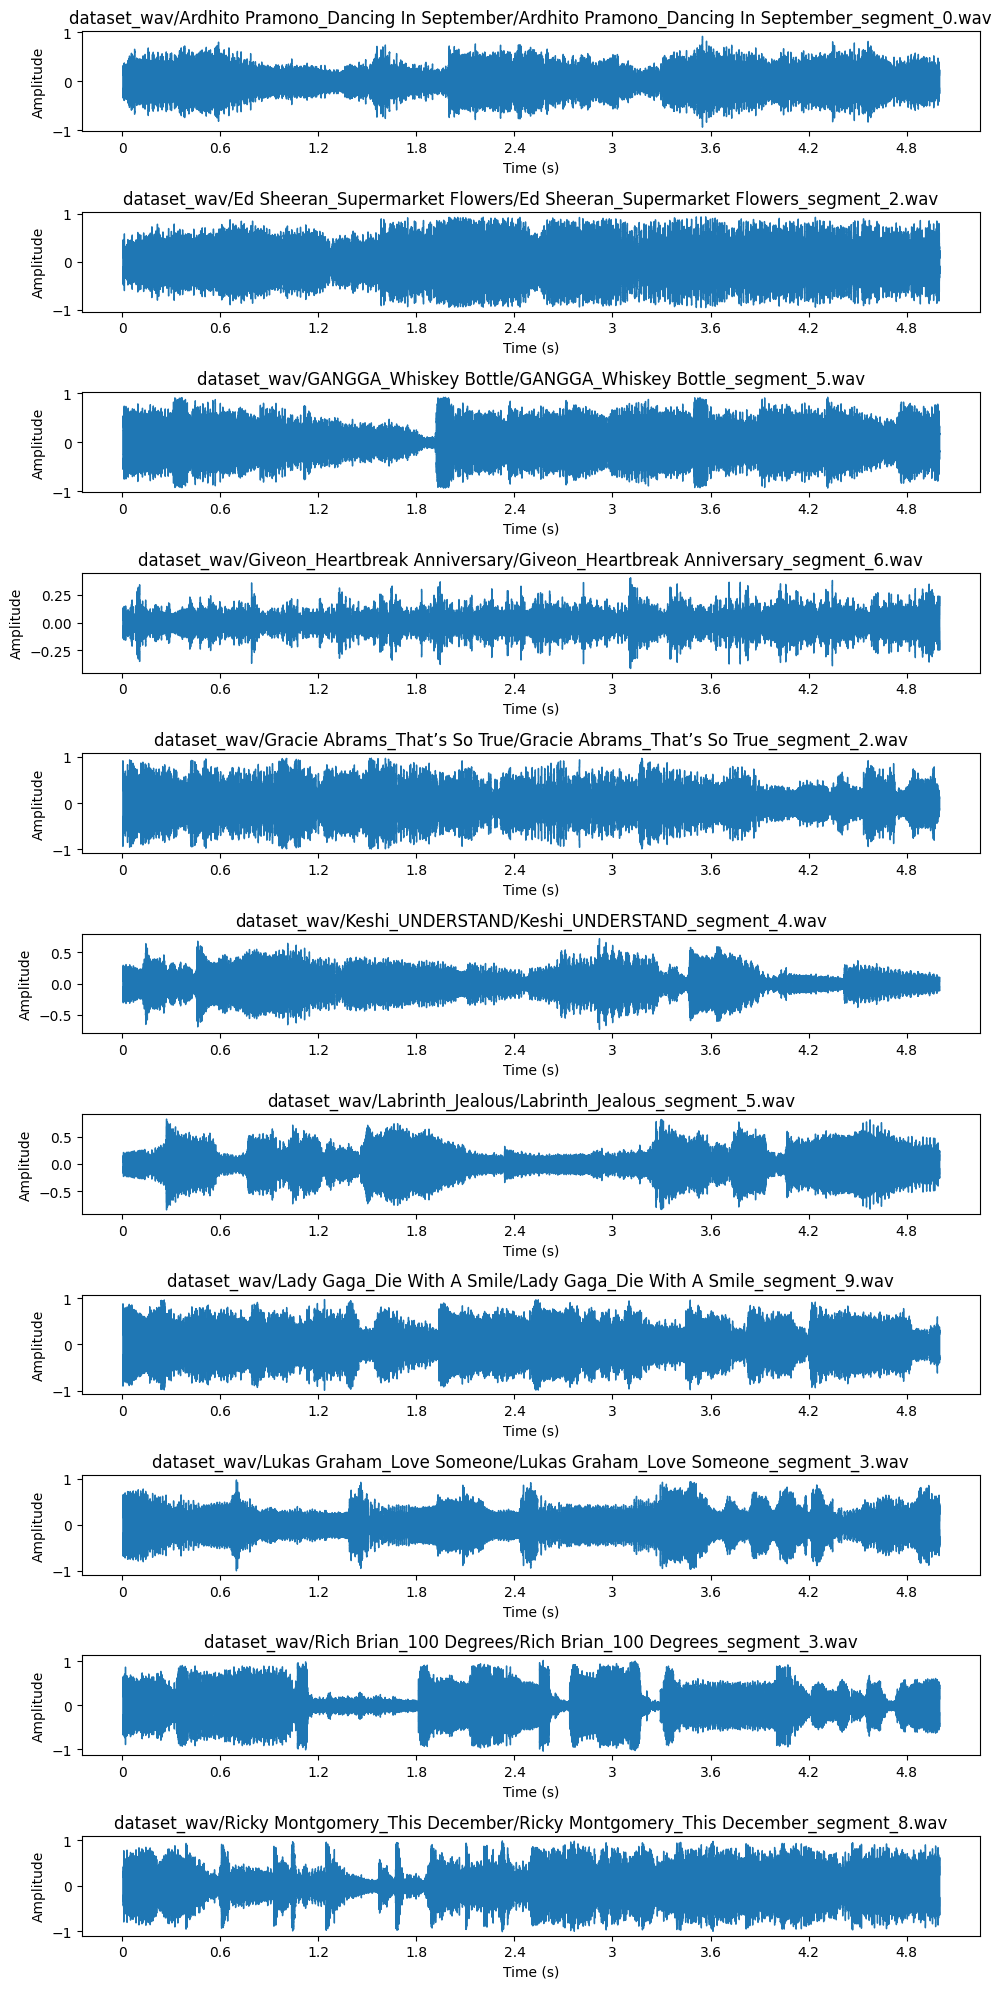

In [4]:
SAMPLE_RATE = 22050
files = [
    "dataset_wav/Ardhito Pramono_Dancing In September/Ardhito Pramono_Dancing In September_segment_0.wav",
    "dataset_wav/Ed Sheeran_Supermarket Flowers/Ed Sheeran_Supermarket Flowers_segment_2.wav",
    "dataset_wav/GANGGA_Whiskey Bottle/GANGGA_Whiskey Bottle_segment_5.wav",
    "dataset_wav/Giveon_Heartbreak Anniversary/Giveon_Heartbreak Anniversary_segment_6.wav",
    "dataset_wav/Gracie Abrams_That’s So True/Gracie Abrams_That’s So True_segment_2.wav",
    "dataset_wav/Keshi_UNDERSTAND/Keshi_UNDERSTAND_segment_4.wav",
    "dataset_wav/Labrinth_Jealous/Labrinth_Jealous_segment_5.wav",
    "dataset_wav/Lady Gaga_Die With A Smile/Lady Gaga_Die With A Smile_segment_9.wav",
    "dataset_wav/Lukas Graham_Love Someone/Lukas Graham_Love Someone_segment_3.wav",
    "dataset_wav/Rich Brian_100 Degrees/Rich Brian_100 Degrees_segment_3.wav",
    "dataset_wav/Ricky Montgomery_This December/Ricky Montgomery_This December_segment_8.wav"
]

fig, axes = plt.subplots(nrows=len(files), figsize=(10, 20))

for i, file_path in enumerate(files):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    axes[i].set_title(file_path)
    librosa.display.waveshow(signal, sr=sr, ax=axes[i])
    axes[i].set_xlabel("Time (s)")
    axes[i].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [6]:
import random
def augment_audio(signal, sr):

    rate = random.uniform(0.8, 1.2)
    stretched_signal = librosa.effects.time_stretch(signal, rate=rate)

    steps = random.randint(-5, 5)
    shifted_signal = librosa.effects.pitch_shift(signal, sr=sr,n_steps=steps)

    noise_factor = 0.005
    noise = np.random.randn(len(signal))
    noisy_signal = signal + noise_factor * noise

    return [stretched_signal, shifted_signal, noisy_signal]

In [7]:
DATASET_PATH = "dataset_wav"

num_samples_per_segment = int(SAMPLE_RATE * 5 / NUM_SEGMENTS)
expected = math.ceil(num_samples_per_segment / HOP_LENGTH)

def mfcc(data_set):
    features = []
    labels = []

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(data_set)):
        if dirpath != data_set:
            label = dirpath.split("/")[-1]
            print("\nProcessing {}".format(label))

            for filename in filenames:
                file_path = os.path.join(dirpath, filename)
                signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                for s in range(NUM_SEGMENTS):
                    start_sample = num_samples_per_segment * s
                    finish_sample = start_sample + num_samples_per_segment

                    mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample], sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
                    mfcc = mfcc.T

                    if len(mfcc) == expected:
                        features.append(mfcc.tolist())
                        labels.append(label)
                        print("{}, segment:{}".format(file_path, s + 1))

                augmented_signals = augment_audio(signal, sr=SAMPLE_RATE)
                for augmented_signal in augmented_signals:
                    for s in range(NUM_SEGMENTS):
                        start_sample = num_samples_per_segment * s
                        finish_sample = start_sample + num_samples_per_segment

                        mfcc = librosa.feature.mfcc(y=augmented_signal[start_sample:finish_sample], sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
                        mfcc = mfcc.T

                        if len(mfcc) == expected:
                            features.append(mfcc.tolist())
                            labels.append(label)
                            print("Augmented, {}, segment:{}".format(file_path, s + 1))

    return np.array(features), np.array(labels)

mfccs, labels = mfcc(DATASET_PATH)



Processing dataset_wav\Ardhito Pramono_Dancing In September
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:1
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:2
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:3
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:4
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:5
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:6
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:7
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:8
dataset_wav\Ardhito Pramono_Dancing In September\Ardhito Pramono_Dancing In September.wav, segment:9
dataset_wav\Ardhito Pramono_Da

c:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=606
  warnings.warn(


Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_1.wav, segment:1
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_1.wav, segment:2
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_1.wav, segment:3
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_1.wav, segment:4
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_1.wav, segment:5
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_1.wav, segment:6
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_1.wav, segment:7
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_1.wav, segment:8
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_1.wav, segment:1
Augmented,

c:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_2.wav, segment:1
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_2.wav, segment:2
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_2.wav, segment:3
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_2.wav, segment:4
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_2.wav, segment:5
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_2.wav, segment:6
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_2.wav, segment:7
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_2.wav, segment:8
Augmented, dataset_wav\Ed Sheeran_Supermarket Flowers\Ed Sheeran_Supermarket Flowers_segment_2.wav, segment:9
Augmented,

c:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Programs\Python\Python310\lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=149
  warnings.warn(


Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav, segment:1
Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav, segment:2
Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav, segment:3
Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav, segment:4
Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav, segment:5
Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav, segment:6
Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav, segment:7
Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav, segment:8
Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav, segment:1
Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav, segment:2
Augmented, dataset_wav\Lauv_First Heartbreak\Lauv_First Heartbreak_segment_8.wav

In [8]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

mfccs = mfccs[...,np.newaxis]

x_train,x_temp,y_train,y_temp = train_test_split(mfccs,labels,test_size = 0.4,random_state = 42,shuffle=True)
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size = 0.5,random_state = 42,shuffle=True)

In [9]:
model = models.Sequential(
    [
        layers.Input(shape=(expected, N_MFCC, 1)),
        layers.Conv2D(filters=24, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D((4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=48, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D((4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(filters=48, kernel_size=(5, 5), activation="relu", padding='same'),
        layers.MaxPooling2D((4, 4), strides=(2, 2), padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(12, activation="softmax"),  
    ]
)

font = ImageFont.truetype("arial.ttf", 12)
visualkeras.layered_view(model, legend=True, font=font).show()

c:\Users\KR24-1.SOFTWARELABCNTR\AppData\Local\Programs\Python\Python310\lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [10]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (3112, 22, 13, 1)
Shape of y_train: (3112,)
Shape of x_val: (1038, 22, 13, 1)
Shape of y_val: (1038,)
Shape of x_test: (1038, 22, 13, 1)
Shape of y_test: (1038,)


In [11]:
print(f"Unique labels in the dataset: {np.unique(labels)}")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32, 
    callbacks=[reduce_lr, early_stopping],
    verbose=1  
)

Unique labels in the dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Epoch 1/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1414 - loss: 2.6087 - val_accuracy: 0.2254 - val_loss: 2.3622 - learning_rate: 1.0000e-04
Epoch 2/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3112 - loss: 1.9958 - val_accuracy: 0.4518 - val_loss: 2.0433 - learning_rate: 1.0000e-04
Epoch 3/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4260 - loss: 1.7149 - val_accuracy: 0.5607 - val_loss: 1.6624 - learning_rate: 1.0000e-04
Epoch 4/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5015 - loss: 1.5435 - val_accuracy: 0.5877 - val_loss: 1.3865 - learning_rate: 1.0000e-04
Epoch 5/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5724 - loss: 1.3600 - val_accuracy: 0.6262 - val_loss: 1.2216 - learning_rate: 1.0000e-04
Epoch 6/50
98/98 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6114 - loss: 1.2614 - val_accuracy: 0.6464 - val_loss: 1.1226 - learning_rate: 1.0000e-04
Epoch 7/

In [12]:
score = model.evaluate(x_test,y_test)
print (f"Test Loss : {score[0]}")
print (f"Test Accuracy : {score[1]}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8430 - loss: 0.4966
Test Loss : 0.5257003903388977
Test Accuracy : 0.8420038819313049


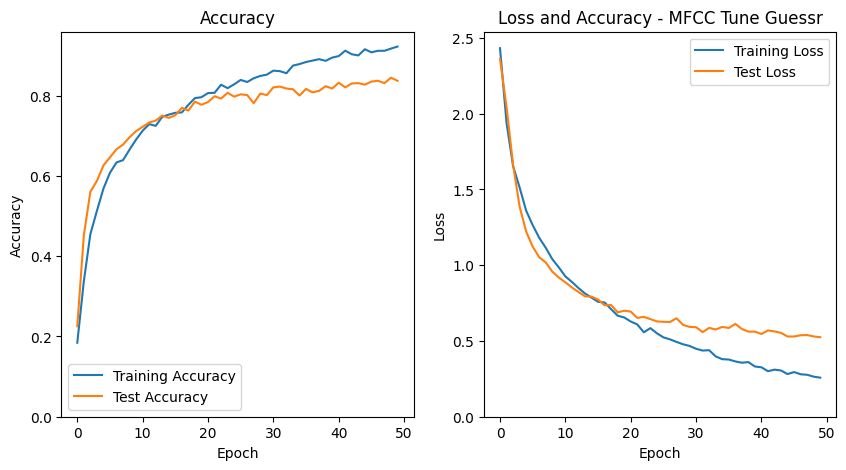

In [13]:
acc = history.history['accuracy']  
val_acc = history.history['val_accuracy'] 

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Test Accuracy")
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(bottom=0)

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Test Loss")
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.savefig('mfcc_loss_accuracy.png')
plt.title('Loss and Accuracy - MFCC Tune Guessr')
plt.show()

In [14]:
import pickle
with open('/nice2.pkl','wb') as a:
    pickle.dump(model,a)

In [15]:
from collections import Counter
label_to_song = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))

def predict_song(file_path):
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
    num_segments = math.ceil(len(signal) / num_samples_per_segment)

    predictions = []

    for s in range(num_segments):
        start_sample = num_samples_per_segment * s
        end_sample = start_sample + num_samples_per_segment

        segment = signal[start_sample:end_sample]
        mfcc_features = librosa.feature.mfcc(
            y=segment, sr=SAMPLE_RATE, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH
        )
        mfcc_features = mfcc_features.T[np.newaxis, ..., np.newaxis]

        prediction = model.predict(mfcc_features)
        predicted_label = np.argmax(prediction)
        predictions.append(predicted_label)

    most_common_label = Counter(predictions).most_common(1)[0][0]
    print(f"Predicted label: {most_common_label}")

    predicted_song = label_to_song[most_common_label]
    return predicted_song



In [16]:
new_file_path = "dataset_wav/GANGGA_Whiskey Bottle/GANGGA_Whiskey Bottle_segment_5.wav"
predicted_song = predict_song(new_file_path)
path_parts = predicted_song.split("\\")[-1]  
artist, song = path_parts.split("_")  

print(f"Predicted Artist: {artist}")
print(f"Predicted Song: {song}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted label: 2
Predicted Artist: GANGGA
Predicted Song: Whiskey Bottle


In [17]:
model.save("model.keras")